In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from itertools import chain

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)'

Using TensorFlow backend.


In [2]:
# entire corpus
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [3]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence      : ", maxLen)
print("Number of words       : ", len(vocabulary))
print("Number of norm. words : ", len(vnorm))
print("Number of POS tags    : ", numClasses)
print("Number of supertags   : ", numSuperClasses)



Longest sentence      :  266
Number of words       :  30300
Number of norm. words :  28223
Number of POS tags    :  32
Number of supertags   :  891


In [4]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


In [145]:

def get_features(string, cat):
    fset = set()

    if (cat == "v"):
        m0 = re.search(r"<(.*)>", string)
        if m0 is not None:
            for item in m0.group(1).split(','):
                fset.add(item)

    m1 = re.search(r"cat=(.*?)[,\]]", string)
    if m1 is not None:
        fset.add(m1.group(1))

    for m2 in re.findall(r"@(.*?)[,\]]", string):
        if not (m2 == "e"):
            fset.add(m2)
    return fset
  

In [173]:
possessive_features = set(['p_P1s', 'p_P2s', 'p_P3s', 'p_P1p', 'p_P2p', 'p_P3p',\
                           'fs_P1s', 'fs_P2s', 'fs_P3s',\
                           's_P1s', 's_P2s', 's_P3s', 's_P1p', 's_P2p', 's_P3p'])

verb_inflection_features = set(['P1s', 'P12s', 'P2s', 'P3s', 'P1p', 'P2p', 'P3p',\
                                'J1s', 'J12s', 'J2s', 'J3s', 'J1p', 'J2p', 'J3p',\
                                'T1s', 'T2s', 'T3s', 'T1p', 'T2p', 'T3p',\
                                'F1s', 'F2s', 'F3s', 'F1p', 'F2p', 'F3p',\
                                'C1s', 'C12s', 'C3s', 'C1p', 'C2p', 'C3p',\
                                'S1s', 'S13s', 'S2s', 'S3s', 'S1p', 'S2p', 'S3p',\
                                'Y2s', 'Y1p','Y2p', 'G', 'W',\
                                'I1s', 'I12s', 'I3s', 'I1p', 'I2p', 'I3p',\
                                'PS13s', 'PS3','PS2s', 'PS3p',\
                                'PJ12s', 'ST2s',\
                                'K', 'Km', 'Kms', 'Kfs', 'Kmp', 'Kfp'])

inflection_features = set(['ms', 'mp', 'fs', 'fp', '1s', '2s', '3s', '1p', '2p', '3p', '3fs', '3mp', '3fp'])

object_map  = { 'Obj:(cla|sn)':'sn', 'Obj:cla|qcompl|scompl|sinf|sn':'qcompl|scompl|sinf|sn',\
             'Obj:cla|scompl|sn':'scompl|sn', 'Obj:cla|de-sinf|sn':'de-sinf|sn',\
             'Obj:sinf':'sinf', 'Obj:(cla|scompl|sn)':'scompl|sn',\
             'Obj:(cla|scompl|sinf|sn)':'scompl|sinf|sn', 'Obj:(cla|seréc|seréfl|sn)':'sn',\
             'Obj:(à-sinf)':'à-sinf', 'Obj:cla|qcompl|scompl|sn':'qcompl|scompl|sn',\
             'Obj:(scompl|sinf)':'scompl|sinf', 'Obj:(cla|pour-sn|sn)':'pour-sn|sn',\
             'Obj:(cla|de-sinf|scompl|sn)':'de-sinf|scompl|sn', 'Obj:cla|scompl|sinf|sn':'scompl|sinf|sn',\
             'Obj:à-sinf':'à-sinf', 'Obj:(cla|de-sinf|sn|à-sinf)':'de-sinf|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sn)':'qcompl|scompl|sn', 'Obj:(cla|de-sinf|sn)':'de-sinf|sn',\
             'Obj:de-sinf':'de-sinf', 'Obj:(cla|qcompl|scompl|sn|à-sinf)':'qcompl|scompl|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sinf|sn)':'qcompl|scompl|sinf|sn', 'Obj:cla|sn':'sn',\
             'Obj:(cla|de-sinf|qcompl|scompl|sn)':'de-sinf|qcompl|scompl|sn',\
             'Obj:sn':'sn', 'Obj:scompl':'scompl', 'Obj:qcompl':'qcompl', 'Obj:pour-sn':'pour-sn'}


In [174]:
def transform_features(valset):
    features = set()
    for val in valset:
        if val in possessive_features:
            features.add("possessive")
        elif val in verb_inflection_features:
            fts = list(val)
            features.union(fts)
        elif val in inflection_features:
            fts = list(val)
            features.union(fts)
        elif val == "Obl:en-sn":
            features.add("Obl:(en-sn)")
        elif val == "Att:pour-sa|pour-sn":
            features.add("Att:(pour-sa|pour-sn)")
        elif val.startswith("Suj:"):
            None
        elif val.startswith("Objà:"):
            features.add("Objà")
        elif val.startswith("Objde:"):
            features.add("Objde")
        elif val.startswith("Obj:"):
            tmp = object_map[val]
            lst = tmp.split('|')
            for l in lst:
                features.add("Obj:" + l)
        else:
            features.add(val)
            
    return features

In [175]:

def read_lefff(file):
    vocabulary = set()
    tags = set()
    word_pos_map = {}
    max_word_len = 0
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split("\t")
            w = line[0]
            w = w.replace("æ", "ae")
            w = w.replace("œ", "oe")
            w = w.replace("-_", "-")
            word_len = len(w)
            if (word_len > max_word_len):
                max_word_len = word_len
            wlist = w.split()
            if (len(wlist) == 2):
                w = wlist[0]
                nextfeat == None
                if (wlist[1]).startswith("qu'"):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("que "):
                    nextfeat = "Next:que"
                if (wlist[1] == 'que'):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("d'"):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("de "):
                    nextfeat = "Next:de"
                if (wlist[1] == 'de'):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("à "):
                    nextfeat = "Next:à"
                if (wlist[1] == 'à'):
                    nextfeat = "Next:à"
                if (wlist[1] == 'priori'):
                    nextfeat = "Next:priori"
            elif (len(wlist) == 1):
                nextfeat = None
                
            if (w[0].find("_") == -1 and (len(wlist) == 1) or ((len(wlist) ==2) and (nextfeat is not None))):
                if (w == "c'est-à-dire"):
                    w = "est-à-dire"
                    nextfeat = "Prev:ce"
                pos = line[2]
                features = line[3]
                vocabulary.add(w)
                valset = word_pos_map.get(w)
                if valset is None:
                    valset = set()
                valset.add(pos)
                fts = get_features(features, pos)
                valset = valset.union(fts)
                if nextfeat is not None:
                    valset.add(nextfeat)
                valset = transform_features(valset)
                word_pos_map[w] = valset

    for w in ['capella', 'contratio', 'fortiori', 'latere', 'minima', 'posteriori',  'priori']:
        word_pos_map[w] = set(['priori'])
                
    for key in iter(word_pos_map.keys()):
        word_pos_map[key] = frozenset(word_pos_map[key])
        
    for val in iter(word_pos_map.values()):
        tags.add(val)
        
    return vocabulary, tags, word_pos_map, max_word_len


In [176]:
v, t, wpm, maxWordLen = read_lefff('lefff-ext-3.0.txt')

In [ ]:
print(maxWordLen)
print(t)

In [ ]:
print(len(t))

In [ ]:
print(wpm["Jean"])

In [ ]:
print(wpm["est"])

In [ ]:
print(wpm["été"])

In [177]:
print(wpm["était"])

frozenset({'fêtre', 'Att:(sa|à-sinf|à-sn)', 'pers', 'AttSuj', 'auxEtre', 'Att:(de-sinf|scompl|sn)', 'v'})


In [ ]:
print(wpm["faut"])

In [ ]:
print(wpm["que"])

In [ ]:
print(wpm["qu'"])

In [ ]:
print(wpm["priori"])

In [ ]:
print(wpm["importe"])

In [ ]:
print(len(v))

In [178]:
fset = set()
for frozen in t:
    for f in frozen:
        fset.add(f)
print(fset)
print(len(fset))
outFeatures = len(fset)+1

{'prel', 'Obl:(pour-sn)', 'Obj:scompl', 'cla', 'clar', 'ce', 'Obl:(pour-sinf|sinf)', 'AttObj', 'Att:(pour-sa|pour-sn)', '3ms', 'Obl2:(par-sn)', 'Obl:(contre-sn|sur-sn)', 'CtrlObjObl', 'clneg', 'advneg', 'Att:(cla|sn)', 'parento', 'poncts', 'Obl:(contre-sn)', 'pseudo-en_possible', 'ACompSubj', 'Loc:(dans-sn|y)', 'Loc:(cll|loc-sn)', 'Loc:(y|à-sn)', 'Att:(comme-sa|comme-sn|sa|sinf|sn)', 'se_moyen', 'Obl:(par-sn)', 'Obl:(dans-sn)', 'Obl:(sous-sn)', 'Obl:(après-sn)', 'np', 'n', 'CompSubj', 'Obl2:(contre-sn)', 'pro_loc', 'Next:priori', 'Obj:sinf', 'Att:(sn)', 'adj', 'Obl:(avec-sn)', 'hum', 'CtrlSujObj', 'Next:que', 'cf', 'cfi', 'time', 'adv', 'cll', 'Loc:(loc-sn|sinf|y)', 'ponctw', 'cln', 'epsilon', 'parentf', 'être', 'Obl2:(loc-sn)', 'CtrlSujLoc', 'Obl:(sur-sn)', 'advm', 'active', 'poss', 'pri', 'prep', 'cld', 'Att:de-sa|de-sn', 'Obl:(à-sinf)', 'auxAvoir', 'Loc:(sur-sn)', 'sym', 'coo', 'CtrlObjObjde', 'Loc:loc-sn|sinf|y', 'CtrlSujAtt', 'Obl:(pour-sinf)', 'clg', 'p', 'Loc:loc-sn|y', 'Obl:(de

In [179]:
feature_to_integer, integer_to_feature = indexify(fset)

In [181]:
print(X[0])
print(integer_to_feature[140])

['Lyonnaise-Dumez', 'vient', "d'", 'hispaniser', 'sa', 'filiale', 'espagnole', 'et', "d'", 'étendre', 'ses', 'participations', 'en', 'Espagne', ',', 'tout', 'en', 'resserrant', 'ses', 'liens', 'avec', 'la', 'Caixa', ',', 'première', 'caisse', "d'", 'épargne', 'espagnole', 'et', "l'", 'un', 'des', 'premiers', 'établissements', 'financiers', 'de', 'la', 'péninsule', 'ibérique', ',', 'à', 'laquelle', 'elle', 'est', 'liée', 'depuis', 'longtemps', 'dans', 'la', 'Société', 'générale', 'des', 'eaux', 'de', 'Barcelone', '(', 'SGAB', ')', ',', 'premier', 'groupe', 'espagnol', 'de', 'services', '(', 'la', 'Caixa', 'détient', 'aussi', '2', '%', 'du', 'capital', 'de', 'Lyonnaise-Dumez', ')', '.']
pro_nom


In [182]:
def get_characters(vocabulary):

    characters = set(['^', 'Û', '³', 'Ê', '<BOS>', '<BOW>', '<EOW>', '<EOS>', '<UNK>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    for word in vocabulary:
        clist = list(word)
        for char in clist:
            characters.add(char)
    
    remove = set(['|', '«', '»', 'µ', '§', 'þ', 'ø', '_', '¯', 'ð', 'æ', '~', '©', '@', '~'])
    
    return characters - remove

In [183]:
characters = get_characters(v)
print(characters)
print(len(characters))

maxChars = len(characters)

character_to_integer, integer_to_character = indexify(characters)

{'ì', '<BOW>', 'õ', '°', 'Ê', 'a', 'O', '<BOS>', '<EOS>', 'º', '/', ';', '5', 'x', 'j', 'o', '9', 'C', 'Y', 'n', 'E', 'Á', 'T', 'à', '<', 'P', '4', 'X', 'G', 'â', '½', 'k', 'Û', "'", 'D', 'ê', 't', '³', 'í', 'M', 'ü', '0', 'R', 'U', '8', 'I', '?', ')', '!', 'h', 'î', '+', 'È', 'À', 'ö', 'å', '<EOW>', '=', '1', 'p', '<UNK>', 'ë', 'W', 'i', 'J', 'ô', 'ñ', 'V', 'l', '$', 'ä', '^', 'è', 'e', 'ç', ':', 'S', 'á', 'Z', 'w', 'v', 'g', 'Q', 'f', 'm', '6', 'é', '%', 'q', 'u', 'r', ',', 'd', '2', 'ï', 'É', 'c', 'Å', '[', 'Ç', '*', 'H', 'ã', '-', '(', 'û', 'b', 'z', '²', 'N', '"', 'F', 'L', 'B', 'ò', '>', 'ú', ']', 'ù', 'y', 'K', '.', 'A', 'Î', 'ó', '7', 's', '3', '&', '±'}
130


In [184]:
mapping = {}

mapping["="] = set(['math', 'infix'])
mapping["<"] = set(['math', 'infix'])
mapping[">"] = set(['math', 'infix'])


mapping["+"] = set(['math', 'infix'])
mapping["*"] = set(['math', 'infix'])
mapping["±"] = set(['math', 'prefix'])
mapping["°"] = set(['math', 'postfix'])
mapping["º"] = set(['math', 'postfix'])
mapping["²"] = set(['math', 'postfix'])
mapping["³"] = set(['math', 'postfix'])



mapping["0"] = set(['9'])
mapping["1"] = set(['9'])
mapping["2"] = set(['9'])
mapping["3"] = set(['9'])
mapping["4"] = set(['9'])
mapping["5"] = set(['9'])
mapping["6"] = set(['9'])
mapping["7"] = set(['9'])
mapping["8"] = set(['9'])
mapping["½"] = set(['9'])

mapping["A"] = set(['a', 'maj'])
mapping["B"] = set(['b', 'maj'])
mapping["C"] = set(['c', 'maj'])
mapping["D"] = set(['d', 'maj'])
mapping["E"] = set(['e', 'maj'])
mapping["F"] = set(['f', 'maj'])
mapping["G"] = set(['g', 'maj'])
mapping["H"] = set(['h', 'maj'])
mapping["I"] = set(['i', 'maj'])
mapping["J"] = set(['j', 'maj'])
mapping["K"] = set(['k', 'maj'])
mapping["L"] = set(['l', 'maj'])
mapping["M"] = set(['m', 'maj'])
mapping["N"] = set(['n', 'maj'])
mapping["O"] = set(['o', 'maj'])
mapping["P"] = set(['p', 'maj'])
mapping["Q"] = set(['q', 'maj'])
mapping["R"] = set(['r', 'maj'])
mapping["S"] = set(['s', 'maj'])
mapping["T"] = set(['t', 'maj'])
mapping["U"] = set(['u', 'maj'])
mapping["V"] = set(['v', 'maj'])
mapping["W"] = set(['w', 'maj'])
mapping["X"] = set(['x', 'maj'])
mapping["Y"] = set(['y', 'maj'])
mapping["Z"] = set(['z', 'maj'])

mapping["á"] = set(['a', 'aigu'])
mapping["à"] = set(['a', 'grave'])
mapping["ä"] = set(['a', 'uml'])
mapping["â"] = set(['a', 'circ'])
mapping["ã"] = set(['a', 'tilde'])
mapping["å"] = set(['a'])

mapping["ç"] = set(['c', 'cedil'])

mapping["é"] = set(['e', 'aigu'])
mapping["è"] = set(['e', 'grave'])
mapping["ê"] = set(['e', 'circ'])
mapping["ë"] = set(['e', 'uml'])


mapping["ï"] = set(['i', 'uml'])
mapping["í"] = set(['i', 'aigu'])
mapping["î"] = set(['i', 'circ'])
mapping["ì"] = set(['i', 'grave'])

mapping["ñ"] = set(['n', 'tilde'])

mapping["ö"] = set(['o', 'uml'])
mapping["ó"] = set(['o', 'aigu'])
mapping["õ"] = set(['o', 'tilde'])
mapping["ô"] = set(['o', 'circ'])
mapping["ò"] = set(['o', 'grave'])
mapping["ò"] = set(['o', 'grave'])


mapping["û"] = set(['u', 'circ'])
mapping["ú"] = set(['u', 'aigu'])
mapping["ù"] = set(['u', 'grave'])
mapping["ü"] = set(['u', 'uml'])

mapping["Á"] = set(['a', 'maj', 'aigu'])
mapping["À"] = set(['a', 'maj', 'grave'])
mapping["Å"] = set(['a', 'maj'])

mapping["Ç"] = set(['c', 'maj', 'cedil'])

mapping["È"] = set(['e', 'maj', 'grave'])
mapping["É"] = set(['e', 'maj', 'aigu'])
mapping["Ê"] = set(['e', 'maj', 'circ']) 

mapping["Î"] = set(['i', 'maj', 'circ'])

mapping["Û"] = set(['u', 'maj', 'circ'])



In [185]:
def compute_symset (characters, mapping):
    symset = set()
    for c in characters:
        try:
            syms = mapping[c]
            symset = symset.union(syms)
        except:
            symset.add(c)
    return symset

In [186]:
sset = compute_symset(characters, mapping)
print(sset)

maxCharFeat = len(sset)+1
print(len(sset))

print(mapping['+'])

{'circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'}
61
{'math', 'infix'}


In [187]:
def char_to_charfeatures (char, mpg, symbset):
    try:
        feats = mpg[char]
    except:
        if (char in symbset):
            feats = set([char])
        else:
            feats = set(['<UNK>'])
    
    return feats

In [188]:
char_to_charfeatures("A", mapping, sset)

{'a', 'maj'}

In [189]:
charf_to_integer, integer_to_charf = indexify(sset)

In [190]:
charf_to_integer.keys()

dict_keys(['circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'])

In [191]:
def char_to_one_hot(char, mpg, c_to_in, symbset, mcf):
    fset = char_to_charfeatures(char, mpg, symbset)
    numf = len(fset)
    
    tmp = np.zeros(numf)
    index = 0
    for item in fset:
        tmp[index] = c_to_in[item]
        index = index + 1
    Y = to_categorical(tmp, mcf)
    return np.sum(Y,axis=0)
   

In [192]:
Y0 = char_to_one_hot("A", mapping, charf_to_integer, sset, maxCharFeat)

print(Y0)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [193]:
transform = np.zeros((maxChars+1, maxCharFeat))
for char, i in character_to_integer.items():
    transform[i] = char_to_one_hot(char, mapping, charf_to_integer, sset, maxCharFeat)
    
np.shape(transform)

(131, 62)

In [194]:
def word_to_one_hot(word, mpg, c_to_in, symbset, mcf, bos, eos):
    ls = list(word)
    length = len(ls)+2
    end = length - 1
    Y = np.zeros((length,mcf))
    if bos:
        Y[0] = char_to_one_hot('<BOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[0] = char_to_one_hot('<BOW>', mpg, c_to_in, symbset, mcf)
    if eos:
        Y[end] = char_to_one_hot('<EOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[end] = char_to_one_hot('<EOW>', mpg, c_to_in, symbset, mcf)

    for i in range(0,end-1):
        Y[i+1] = char_to_one_hot(ls[i], mpg, c_to_in, symbset, mcf)
        
    return Y

In [195]:
Jean = word_to_one_hot('Jean', mapping, charf_to_integer, sset, maxCharFeat, True, True)
print(np.shape(Jean))
print(Jean)

(6, 62)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [196]:
totalWords = 0
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        totalWords = totalWords + 1
  
print(totalWords)

264432


In [197]:
def compute_total_words(word_matrix):
  
    tw = 0
    
    for i in range(len(word_matrix)):
        for j in range(len(word_matrix[i])):
             tw = tw + 1

    return tw


In [198]:
def word_matrix_to_charint_matrix(word_matrix, max_chars):
 
    total_words = compute_total_words(word_matrix)
    
    X_charint = np.zeros((total_words,max_chars))
    
    xindex = 0

    # iterate over sentences in input matrix
    for i in range(len(word_matrix)):
        end = len(word_matrix[i])
        # iterater over words in sentences
        for j in range(len(word_matrix[i])):
            charslist = list(word_matrix[i][j])
            # add beginning/end of word/sentence tags to word
            if (j == 0):
                X_charint[xindex][0] = character_to_integer['<BOS>']
            else:
                X_charint[xindex][0] = character_to_integer['<BOW>']
            if (j == end-1):
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOS>']
            else:
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOW>']
            for c in range(len(charslist)):
                d = c + 1
                char = charslist[c]
                try:
                    X_charint[xindex][d] = character_to_integer[char]
                except:
                    # warn when unknown character is encountered
                    print("Unknown character: ", end='')
                    print(i, end=' ')
                    print(charslist)
            # increase word counter
            xindex = xindex + 1
    return X_charint

In [199]:
X_charint_input = word_matrix_to_charint_matrix(X_train, maxChars)

In [200]:
print(np.shape(X_charint_input))
print(X_charint_input[5])

(264432, 130)
[  2.  92.  57.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [201]:
print(X_train[397])
print(character_to_integer['U'])

['-', '^', 'Reuters', 'Doctoring', 'Photos', 'from', 'Beirut', '?']
44


In [202]:
# compensate for some missing words in lefff

def outword_mapping(word):
    lword = word.lower()
    if lword == "auquel":
        return set(['à', 'lequel'])
    if lword == "auxquels":
        return set(['à', 'lesquels'])
    if lword == "auxquelles":
        return set(['à', 'lesquelles'])
    if lword == "aux":
        return set(['à', 'les'])
    if lword == "duquel":
        return set(['de', 'lequel'])
    if lword == "desquels":
        return set(['des', 'lesquels'])
    if lword == "desquelles":
        return set(['des', 'lesquelles'])
    if lword == "des":
         return set(['de', 'les'])
    if lword == "au":
        return set(['à', 'le'])
    if lword == "du":
         return set(['de', 'le'])
    if lword == "deçà":
         return set(['dessous'])
    if word == "Etat":
         return set(["état"])
    if len(word) == 1 and word.isupper:
        return set(['Alpha'])
    if is_numeral(word):
        return set(["dix-sept"])
    if word == "CNRS":
        return set(['centre'])
    if word == "CRS":
        return set(['centre'])
    if word == "CSA":
        return set(['compagnie'])
    if word == "EDF":
        return set(['électricité'])
    if word == "ANPE":
        return set(['agence'])
    if word == "ONG" or word == "ONU":
        return set(['organisation'])
    if word == "AOC":
        return set(['appelation'])
    if word == "ALENA":
        return set(['accord'])
    if word == "ASSEDIC":
        return set(['association'])
    if word == "PIB":
        return set(['produit'])
    if word == "SMIC":
        return set(['salaire'])


    return set([word])
       

In [203]:
def wordf_to_one_hot(word, outword_mapping, wpm, f_to_in, fset, outf):
    wordset = outword_mapping(word)
    featureset = set()
    for word in wordset:
        if word in wpm.keys():
            featureset = featureset.union(wpm[word])
        else:
            wordl = word.lower()
            if wordl in wpm.keys():
                featureset = featureset.union(wpm[wordl])
            else:
                print("Unknown: ", word)
                featureset = set()
            
    length = len(featureset)
#    Y = np.zeros((length,outf))

    i = 0
    tmp = np.zeros(len(featureset))
    for f in featureset:
        tmp[i] = f_to_in[f]
        i = i + 1
    Y = to_categorical(tmp, outf)

    return np.sum(Y,axis=0)

In [204]:
def normalize_capitals(word):
    word = word.replace("É", "E")
    word = word.replace("Î", "I")
        

In [205]:
vector = wordf_to_one_hot("aux", outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(np.shape(vector))
print(vector)
print(vector[0])

(160,)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.0


In [206]:
print(X_train[0][0])
vec = wordf_to_one_hot(X_train[0][0], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(vec)

Des
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [207]:
def compute_word_targets(X, outword_mapping, wpm, feature_to_integer, fset, outFeatures):

    total_words = compute_total_words(X)
    Y = np.zeros((total_words,outFeatures))

    yindex = 0

    for i in range(len(X)):
        for j in range(len(X[i])):
            Y[yindex] = wordf_to_one_hot(X[i][j], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            yindex = yindex + 1

    return Y

In [208]:
Y_train = compute_word_targets(X_train, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  CBV
Unknown:  Guintoli
Unknown:  ÉTATS-UNIS
Unknown:  Popi
Unknown:  Bayard
Unknown:  HLM
Unknown:  TVA
Unknown:  Doubin
Unknown:  Jean-Louis
Unknown:  Pétriat
Unknown:  FNAC
Unknown:  Ruymbeke
Unknown:  BCCI
Unknown:  Mahfouz
Unknown:  bank
Unknown:  Jean-Yves
Unknown:  Chamard
Unknown:  RPR
Unknown:  UDF
Unknown:  UDC
Unknown:  Etats
Unknown:  Guinée-Equatoriale
Unknown:  Sierra-Léone
Unknown:  Pronasol
Unknown:  M3
Unknown:  Bundesbank
Unknown:  UNIM
Unknown:  Schlesinger
Unknown:  Bundesbank
Unknown:  PS
Unknown:  Etats
Unknown:  Balmary
Unknown:  OCDE
Unknown:  SME
Unknown:  PNB
Unknown:  Etats
Unknown:  RPR
Unknown:  UDF
Unknown:  rétrocommissions
Unknown:  Strauss-Kahn
Unknown:  CNPF
Unknown:  UPA
Unknown:  RMI
Unknown:  Jean-Pierre
Unknown:  Jean-Pierre
Unknown:  PAP
Unknown:  Lodz
Unknown:  Bydgoszcz
Unknown:  Wroclaw
Unknown:  Zielona-Gora
Unknown:  Szczecin
Unknown:  Bérégovoy
Unknown:  Gomez
Unknown:  Eisswein
Unknown:  Thomson
Unknown:  Elettrofinanziaria
Unknown

Unknown:  Nec
Unknown:  GPL
Unknown:  AEG
Unknown:  Lagardère
Unknown:  TF
Unknown:  zig-Zag
Unknown:  Bouygues
Unknown:  DEFICIT
Unknown:  UNEDIC
Unknown:  RDA
Unknown:  Joffre
Unknown:  Who's
Unknown:  next
Unknown:  m2
Unknown:  SCA
Unknown:  SCA
Unknown:  Pelège
Unknown:  Electronique
Unknown:  Bundesbank
Unknown:  CAC
Unknown:  Sirven
Unknown:  Elf
Unknown:  Dumas
Unknown:  L.
Unknown:  C.
Unknown:  Waïkiki
Unknown:  Jean-Louis
Unknown:  Guigou
Unknown:  vingt-huit
Unknown:  MFI
Unknown:  Furniture
Unknown:  group
Unknown:  Bongrain
Unknown:  ULN
Unknown:  Besnier
Unknown:  RVI
Unknown:  Mercedes-Benz
Unknown:  Eltsine
Unknown:  Fath
Unknown:  OLP
Unknown:  Zeid
Unknown:  Wehbé
Unknown:  OLP
Unknown:  Joumblatt
Unknown:  PSP
Unknown:  City
Unknown:  Oxbridge
Unknown:  Cambridge
Unknown:  GATT
Unknown:  PAC
Unknown:  INSEE
Unknown:  Italcementi
Unknown:  Flichy
Unknown:  Bouygues
Unknown:  Courcoux
Unknown:  UAP
Unknown:  FMI
Unknown:  PNB
Unknown:  repreneur
Unknown:  non-respect


Unknown:  Hyundai
Unknown:  BSN
Unknown:  New-York
Unknown:  Vergez
Unknown:  Perigot
Unknown:  Guillen
Unknown:  UIMM
Unknown:  FMI
Unknown:  1er
Unknown:  CSG
Unknown:  CNAM
Unknown:  RSF
Unknown:  immobilier-logement
Unknown:  ROME
Unknown:  Eltsine
Unknown:  Jose
Unknown:  Aznar
Unknown:  directeur-fondateur
Unknown:  Lobry
Unknown:  lavanges
Unknown:  Ruset
Unknown:  CCR
Unknown:  EPIC
Unknown:  Balladur
Unknown:  caméramen
Unknown:  Dupart
Unknown:  TD
Unknown:  OFP
Unknown:  COSEC
Unknown:  IUT
Unknown:  nord-américaines
Unknown:  United
Unknown:  Dupuit
Unknown:  Cournot
Unknown:  chauffeur-routier
Unknown:  onuso-américaine
Unknown:  Jouve
Unknown:  Lambiotte
Unknown:  Saint-Etienne
Unknown:  Marie-Jo
Unknown:  Zimmermann
Unknown:  PLANTU
Unknown:  Milred
Unknown:  Editions
Unknown:  Stern
Unknown:  Tompkins
Unknown:  Limited
Unknown:  Benetton
Unknown:  quatre-vingt-quinze
Unknown:  Renon
Unknown:  SNECMA
Unknown:  Equivalent
Unknown:  stylique
Unknown:  Orkem
Unknown:  Ferra

Unknown:  downgrading
Unknown:  Sombart
Unknown:  Weiss
Unknown:  Krezdorn
Unknown:  PUF
Unknown:  Corradetti
Unknown:  SNEC
Unknown:  devis-type
Unknown:  cuisinistes
Unknown:  devis-type
Unknown:  CNJA
Unknown:  Genève
Unknown:  Montréal
Unknown:  NEC
Unknown:  GATT
Unknown:  HLM
Unknown:  Sombart
Unknown:  Malev
Unknown:  sous-évalués
Unknown:  First
Unknown:  AVU
Unknown:  Delebarre
Unknown:  SCPI
Unknown:  BTP
Unknown:  Héas
Unknown:  Hitler
Unknown:  Barèges
Unknown:  Heyris
Unknown:  CESI
Unknown:  Ile-de-France
Unknown:  valse-hésitation
Unknown:  statu
Unknown:  quo
Unknown:  Mainishi
Unknown:  court-circuite
Unknown:  Angiox
Unknown:  ICP
Unknown:  Eysymontt
Unknown:  Besançon
Unknown:  Elf
Unknown:  francaise
Unknown:  Champs-Elysées
Unknown:  CVS
Unknown:  Bf.G.
Unknown:  Bf.G
Unknown:  Deutschland
Unknown:  Jean-Yves
Unknown:  Haberer
Unknown:  Bf.G
Unknown:  sine
Unknown:  qua
Unknown:  Frydman
Unknown:  Eysymontt
Unknown:  hyperinflation
Unknown:  Sanofi
Unknown:  Bongra

Unknown:  336e
Unknown:  Souain
Unknown:  Halbwax
Unknown:  raccordables
Unknown:  OFCE
Unknown:  Agnelli
Unknown:  Bergons
Unknown:  Zelnick
Unknown:  Virgin
Unknown:  Doubin
Unknown:  FAO
Unknown:  Sopalin
Unknown:  Kimberly-Clark
Unknown:  General
Unknown:  Motors
Unknown:  Thomson
Unknown:  Galliffet
Unknown:  Waldeck-Rousseau
Unknown:  cuisinistes
Unknown:  Abou-Dhabi
Unknown:  Clichois
Unknown:  Schuller
Unknown:  Éric
Unknown:  Halphen
Unknown:  cogénération
Unknown:  MGM
Unknown:  Carolco
Unknown:  Darcet
Unknown:  S.
Unknown:  Kleinwort
Unknown:  OAT
Unknown:  AGA
Unknown:  CEGF
Unknown:  CIM
Unknown:  Thomson
Unknown:  Bf.G
Unknown:  IP
Unknown:  Comtet
Unknown:  Elf
Unknown:  Hezbollah
Unknown:  GPA
Unknown:  Modrow
Unknown:  STASI
Unknown:  Pasqua
Unknown:  Lafont
Unknown:  RON
Unknown:  entrainer
Unknown:  Seveso
Unknown:  Seveso
Unknown:  Juventus
Unknown:  Serie
Unknown:  lean
Unknown:  Rizzo
Unknown:  soixante-quatre
Unknown:  Akers
Unknown:  Cassani
Unknown:  soixante-

Unknown:  LONDRES
Unknown:  Karlsruhe
Unknown:  Limbourg
Unknown:  1er
Unknown:  Stoclet
Unknown:  vidéosphère
Unknown:  graphosphère
Unknown:  logosphère
Unknown:  Debray
Unknown:  Eysymontt
Unknown:  Jean-François
Unknown:  Pilkington
Unknown:  co-entreprise
Unknown:  Pilkington
Unknown:  Sandoglass
Unknown:  SP
Unknown:  Epiphanie
Unknown:  OPEP
Unknown:  CISL
Unknown:  Kleinwort
Unknown:  Peake
Unknown:  BNP
Unknown:  Kaske
Unknown:  Bf.G.
Unknown:  Milutinovic
Unknown:  TPI
Unknown:  Scheveningen
Unknown:  Haye
Unknown:  FMI
Unknown:  Côte-d'ivoire
Unknown:  Abidjan
Unknown:  Reuter
Unknown:  1er
Unknown:  Marie-Agnès
Unknown:  Barrère-Maurisson
Unknown:  PUF
Unknown:  F.
Unknown:  1er
Unknown:  Saurer-Diederichs
Unknown:  Aquamot
Unknown:  Asie-Pacifique
Unknown:  Renon
Unknown:  Jawaharlal
Unknown:  Nehru
Unknown:  Bandoung
Unknown:  air-bag
Unknown:  RMI
Unknown:  Rmistes
Unknown:  là-même
Unknown:  sacro-sainte
Unknown:  Mexès
Unknown:  Attali
Unknown:  Airways
Unknown:  Austr

Unknown:  Victoire-Colonia
Unknown:  New-York
Unknown:  Pittsburgh
Unknown:  Jones
Unknown:  ZDS
Unknown:  PNB
Unknown:  Roddick
Unknown:  conjoncturistes
Unknown:  CBV
Unknown:  contraventionnelles
Unknown:  Exupéry
Unknown:  Jules-Romains
Unknown:  CATE
Unknown:  très-considérable
Unknown:  Sibille
Unknown:  popiwek
Unknown:  Balcerowicz
Unknown:  Schweitzer
Unknown:  Barrau
Unknown:  Kuo
Unknown:  CEE
Unknown:  qualité-prix
Unknown:  Jean-Noël
Unknown:  Kapferer
Unknown:  HEC
Unknown:  OPCVM
Unknown:  COB
Unknown:  OPCVM
Unknown:  Vendôme
Unknown:  UAP
Unknown:  Bruxelles-Lambert
Unknown:  OAT
Unknown:  BTAN
Unknown:  contrario
Unknown:  Time
Unknown:  Levin
Unknown:  Perraudin
Unknown:  Wang
Unknown:  The
Unknown:  European
Unknown:  COB
Unknown:  LRM
Unknown:  H.
Unknown:  Vuong
Unknown:  Indochine
Unknown:  XVII
Unknown:  No.
Unknown:  COMECON
Unknown:  Angiox
Unknown:  bivalirudine
Unknown:  hirudines
Unknown:  Angiox
Unknown:  Genève
Unknown:  Fès
Unknown:  Tchécoslovaquie
Unkn

Unknown:  Chefresne
Unknown:  Lefoulon
Unknown:  Girard
Unknown:  Blainville
Unknown:  17e
Unknown:  Lechat
Unknown:  336e
Unknown:  Reebok
Unknown:  Creeks
Unknown:  Chevignon
Unknown:  Elf
Unknown:  G20
Unknown:  Côte-d'
Unknown:  PCV
Unknown:  CNPF
Unknown:  RCCL
Unknown:  Iskandar
Unknown:  Safa
Unknown:  Gilson
Unknown:  CEE
Unknown:  OCDE
Unknown:  Handelsblatt
Unknown:  Daimler-Benz
Unknown:  Renon
Unknown:  Bouygues
Unknown:  Ford-Volkswagen
Unknown:  Charléty
Unknown:  Excelsior
Unknown:  Marrel
Unknown:  Edbro
Unknown:  Marland
Unknown:  ouistiti-sexe
Unknown:  Lanvin
Unknown:  Pasqua
Unknown:  Béré
Unknown:  Milewski
Unknown:  OFCE
Unknown:  RDA
Unknown:  Guitton
Unknown:  CIC
Unknown:  CIC
Unknown:  Ile-de-France
Unknown:  Jean-Pierre
Unknown:  Aubert
Unknown:  Jean-Luc
Unknown:  Lagardère
Unknown:  Northern
Unknown:  Telecom
Unknown:  Thomson
Unknown:  CSF
Unknown:  Gomez
Unknown:  Jean-Claude
Unknown:  Desjeux
Unknown:  Raissa
Unknown:  longs-métrages
Unknown:  Gilliam
Un

Unknown:  Besançon
Unknown:  OPEP
Unknown:  Bergons
Unknown:  Unilever
Unknown:  Dumas
Unknown:  Tel-Aviv
Unknown:  SNECMA
Unknown:  Mercuria
Unknown:  italo-suisse
Unknown:  Bozzo
Unknown:  Ghosn
Unknown:  Desfossés
Unknown:  repreneur
Unknown:  Valréal
Unknown:  Paribas
Unknown:  Delors
Unknown:  Mermaz
Unknown:  Jean-Pierre
Unknown:  Soisson
Unknown:  yankees
Unknown:  New-York
Unknown:  Bodel
Unknown:  Roosel
Unknown:  Jean-Paul
Unknown:  Lalitte
Unknown:  Rhône-Poulenc
Unknown:  etc
Unknown:  Wagner
Unknown:  Pechiney
Unknown:  MJC
Unknown:  Laske
Unknown:  Albin
Unknown:  Szentes
Unknown:  Kontavill
Unknown:  Delors
Unknown:  Etats
Unknown:  FGAS
Unknown:  PAP
Unknown:  FR3
Unknown:  OCDE
Unknown:  chairman
Unknown:  éco-bilan
Unknown:  Sting
Unknown:  laisser-faire
Unknown:  Cerus
Unknown:  BV
Unknown:  Cerus
Unknown:  Cerus
Unknown:  Waigel
Unknown:  GATT
Unknown:  nord-américain
Unknown:  EEE
Unknown:  Mazowiecki
Unknown:  Vaclav
Unknown:  Sabouret
Unknown:  RTL
Unknown:  Lang

Unknown:  Adidas
Unknown:  société-holding
Unknown:  investment
Unknown:  banks
Unknown:  Chronopost
Unknown:  VEV
Unknown:  COB
Unknown:  Deverloy
Unknown:  Economiste
Unknown:  Syrota
Unknown:  Cogema
Unknown:  RBMK
Unknown:  Tchernobyl
Unknown:  VVER-440
Unknown:  Jean-Noël
Unknown:  Bongrain
Unknown:  soixante-sept
Unknown:  Besnier
Unknown:  soixante-trois
Unknown:  Dodd-Frank
Unknown:  UTA
Unknown:  Bérégovoy
Unknown:  COB
Unknown:  Bundesbank
Unknown:  MITI
Unknown:  Schweitzer
Unknown:  Île-de-France
Unknown:  DATAR
Unknown:  Cinzano
Unknown:  Liberto
Unknown:  Kookaï
Unknown:  Beach
Unknown:  Sassou-Nguesso
Unknown:  Disney
Unknown:  URL
Unknown:  AB
Unknown:  BCE
Unknown:  Bérégovoy
Unknown:  rupiahs
Unknown:  Serang
Unknown:  CNJA
Unknown:  CNPF
Unknown:  Birt
Unknown:  Hurand
Unknown:  Boucault
Unknown:  hors-cadre
Unknown:  75ème
Unknown:  ejido
Unknown:  Christchurch
Unknown:  New
Unknown:  Zealand
Unknown:  Herald
Unknown:  USPA
Unknown:  Lafont
Unknown:  Sabouret
Unknow

Unknown:  LTV
Unknown:  Aerospace
Unknown:  Defense
Unknown:  Sabouret
Unknown:  rauco
Unknown:  suon
Unknown:  tartarea
Unknown:  tromba
Unknown:  CNPF
Unknown:  ARRCO
Unknown:  Sachs
Unknown:  Renon
Unknown:  SNECMA
Unknown:  Bénichou
Unknown:  ALGER
Unknown:  Honda
Unknown:  Mazda
Unknown:  AGF
Unknown:  Nérac
Unknown:  Kwan
Unknown:  Sirven
Unknown:  Elf
Unknown:  CEL
Unknown:  PEL
Unknown:  Genève
Unknown:  Eno
Unknown:  Lessons
Unknown:  how
Unknown:  to
Unknown:  Iraq
Unknown:  The
Unknown:  OCDE
Unknown:  CIB
Unknown:  Patten
Unknown:  Angiox
Unknown:  clopidogrel
Unknown:  Vogelweith
Unknown:  BIE
Unknown:  Leclerc
Unknown:  Lupot
Unknown:  Vuillaume
Unknown:  UAP
Unknown:  Jean-Yves
Unknown:  Drian
Unknown:  RMistes
Unknown:  Maastricht
Unknown:  CSEE
Unknown:  Ingénico
Unknown:  Mérieux
Unknown:  OFCE
Unknown:  Jean-Luc
Unknown:  Lagardère
Unknown:  Northern
Unknown:  Telecom
Unknown:  OPA
Unknown:  STC
Unknown:  HLM
Unknown:  CNPA
Unknown:  TKM
Unknown:  Motors
Unknown:  ca

Unknown:  Genève
Unknown:  Indochine
Unknown:  Delmas
Unknown:  Pagis
Unknown:  BNCI
Unknown:  BNP
Unknown:  nord-américain
Unknown:  linéen
Unknown:  Staedelin
Unknown:  Palazzi
Unknown:  Constantinople
Unknown:  Bosphore
Unknown:  1er
Unknown:  Éric
Unknown:  Halphen
Unknown:  FMI
Unknown:  Mourmelon
Unknown:  1er
Unknown:  DIDIER
Unknown:  Lotharingie
Unknown:  CIP
Unknown:  BELGIQUE
Unknown:  Pinault-Printemps
Unknown:  ISBN
Unknown:  of
Unknown:  Credit
Unknown:  and
Unknown:  BCCI
Unknown:  OCDE
Unknown:  Mc
Unknown:  Guffey
Unknown:  Grand-Prairie
Unknown:  LTV
Unknown:  Thomson
Unknown:  LTV
Unknown:  Clearstream
Unknown:  Cedel
Unknown:  Euroclear
Unknown:  Menem
Unknown:  Eysymontt
Unknown:  Bérégovoy
Unknown:  Northern
Unknown:  Telecom
Unknown:  Elf-Atochem
Unknown:  Yoshitomi
Unknown:  Pharmaceuticals
Unknown:  Akishima
Unknown:  Portelli
Unknown:  Vandingenen
Unknown:  GATT
Unknown:  SED
Unknown:  Modrow
Unknown:  Babangida
Unknown:  Maradona
Unknown:  FRANCFORT
Unknown: 

Unknown:  PCF
Unknown:  conjoncturistes
Unknown:  Taiwan
Unknown:  Paribas
Unknown:  PNB
Unknown:  Delpey
Unknown:  Grancher
Unknown:  Leclerc
Unknown:  FISSIER
Unknown:  SME
Unknown:  USGS
Unknown:  Hajj
Unknown:  Reuters
Unknown:  Solery
Unknown:  New-York
Unknown:  etc
Unknown:  Eltsine
Unknown:  Roddick
Unknown:  Etats
Unknown:  OMS
Unknown:  UNICEF
Unknown:  Louvie
Unknown:  Sodiaal
Unknown:  Nokia
Unknown:  Gilliam
Unknown:  Vinci
Unknown:  France-Antilles
Unknown:  Gerpresse
Unknown:  Nord-matin
Unknown:  Auto-Journal
Unknown:  France-soir
Unknown:  Hyundai
Unknown:  Kia
Unknown:  Ssangyong
Unknown:  Jean-Marc
Unknown:  Varaut
Unknown:  Fachinetti
Unknown:  Emile
Unknown:  Girardin
Unknown:  EAI
Unknown:  Alcatel
Unknown:  BBC
Unknown:  Mtanious
Unknown:  Meurice
Unknown:  Plaza-Athénée
Unknown:  Adidas
Unknown:  logements-passerelles
Unknown:  Mitterrand
Unknown:  po
Unknown:  réalignement
Unknown:  Dynaction
Unknown:  Moretti
Unknown:  Etats
Unknown:  socio-professionnelles
Un

In [209]:
X_dev_charint = word_matrix_to_charint_matrix(X_dev, maxChars)
Y_dev = compute_word_targets(X_dev, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  ULN
Unknown:  Bongrain
Unknown:  Besnier
Unknown:  3e
Unknown:  RPR-UDF
Unknown:  Marti
Unknown:  Lingesler
Unknown:  popularisation
Unknown:  évènemens
Unknown:  Agnelli
Unknown:  Apollonies
Unknown:  ci
Unknown:  ATT
Unknown:  CSN
Unknown:  Hongkong
Unknown:  OAT
Unknown:  Airways
Unknown:  and
Unknown:  General
Unknown:  Workers
Unknown:  Teulade
Unknown:  Ernewein
Unknown:  dix-mille
Unknown:  CSG
Unknown:  Hurand
Unknown:  Wikipédia
Unknown:  Doubin
Unknown:  BNP
Unknown:  Meciar
Unknown:  Vaclav
Unknown:  Tchécoslovaquie
Unknown:  Bank
Unknown:  of
Unknown:  credit
Unknown:  and
Unknown:  BCCI
Unknown:  Jones
Unknown:  Shakespeare
Unknown:  ejideros
Unknown:  Fortech
Unknown:  Tecphy
Unknown:  Egalement
Unknown:  Castro
Unknown:  Théobald
Unknown:  Cottave
Unknown:  Laffore
Unknown:  Toshiba
Unknown:  OM
Unknown:  IPSN
Unknown:  GRS
Unknown:  primo-accession
Unknown:  ULN
Unknown:  Kohl
Unknown:  Sabouret
Unknown:  cours-plancher
Unknown:  SME
Unknown:  Schumacher
Unkno

Unknown:  PNB
Unknown:  Tricentrol
Unknown:  Attali
Unknown:  CVS
Unknown:  recapitalisation
Unknown:  MMB
Unknown:  Pérol
Unknown:  OPAC
Unknown:  Ciolina
Unknown:  PAC
Unknown:  Guyau
Unknown:  stockeur
Unknown:  Hannoun
Unknown:  Bérégovoy
Unknown:  Lagayette
Unknown:  BRGM
Unknown:  Moubarak
Unknown:  Eyadema
Unknown:  Abidjan
Unknown:  FMI
Unknown:  Alenia
Unknown:  Paggio
Unknown:  Rubin
Unknown:  Adidas
Unknown:  Bérégovoy
Unknown:  BFCE
Unknown:  GATT
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  Ocalan
Unknown:  appelation
Unknown:  Nestlé
Unknown:  Barbieux
Unknown:  Lobry
Unknown:  Exor
Unknown:  COB
Unknown:  OPA
Unknown:  Aegon
Unknown:  NV
Unknown:  San-Francisco
Unknown:  Hongkong
Unknown:  sous-traitée
Unknown:  Naples
Unknown:  Moggi
Unknown:  Northern
Unknown:  Telecom
Unknown:  Wadi
Unknown:  Gitaï
Unknown:  Haïfa
Unknown:  radio-télévision
Unknown:  Michelin
Unknown:  Elf
Unknown:  Eastern
Unknown:  Economic
Unknown:  Olipar
Unknown:  Pandraud
Unknown:  Naftalski
U

Unknown:  Godard
Unknown:  Duperier
Unknown:  Muller
Unknown:  BCCI
Unknown:  SNEC
Unknown:  SME
Unknown:  ACEA
Unknown:  RPR
Unknown:  Somatem
Unknown:  CG2A
Unknown:  CGE
Unknown:  Vivendi
Unknown:  Adidas
Unknown:  MTV3
Unknown:  -clés
Unknown:  Tiberi
Unknown:  CCR
Unknown:  privatisables
Unknown:  AFB
Unknown:  New-York
Unknown:  The
Unknown:  Economic
Unknown:  Times
Unknown:  B.
Unknown:  G.
Unknown:  Desmukh
Unknown:  FR3
Unknown:  Northern
Unknown:  Telecom
Unknown:  Sécuripost
Unknown:  struggle
Unknown:  life
Unknown:  CAC
Unknown:  BBC
Unknown:  Akishima
Unknown:  Macmillan
Unknown:  Giraud
Unknown:  fr
Unknown:  Kohl
Unknown:  Mitterrand
Unknown:  Barèges
Unknown:  Echelle
Unknown:  Cassani
Unknown:  Lausanne
Unknown:  GAME
Unknown:  PAC
Unknown:  Yergin
Unknown:  and
Unknown:  Bradstreet
Unknown:  évènement
Unknown:  Eysymontt
Unknown:  TVA
Unknown:  OAT
Unknown:  Michelin
Unknown:  contre-choc
Unknown:  Ghosn
Unknown:  Servan-Schreiber
Unknown:  aincu
Unknown:  Sutherlan

Unknown:  Aircraft
Unknown:  Besançon
Unknown:  Montbéliard
Unknown:  Kopchinsky
Unknown:  Liliane
Unknown:  Bettencourt
Unknown:  Sombart
Unknown:  TVHD
Unknown:  TVHD
Unknown:  Financial
Unknown:  Times
Unknown:  Jean-Claude
Unknown:  Desjeux
Unknown:  Thomson
Unknown:  CSF
Unknown:  Bundesbank
Unknown:  réindustrialiser
Unknown:  Marland
Unknown:  Bull
Unknown:  HN
Unknown:  Zenith
Unknown:  CSEE
Unknown:  Brittan
Unknown:  Nestlé
Unknown:  Maucher
Unknown:  Nestlé
Unknown:  Vevey
Unknown:  spoliatoire
Unknown:  RPR
Unknown:  MGM
Unknown:  moitié-moitié
Unknown:  Wild
Unknown:  CEPII
Unknown:  DM
Unknown:  GFD
Unknown:  Schwartz
Unknown:  Alitalia
Unknown:  Lufthansa
Unknown:  KLM
Unknown:  Airways
Unknown:  Maastricht
Unknown:  Elf
Unknown:  IFP
Unknown:  Elf
Unknown:  ZDS
Unknown:  TBB
Unknown:  Extreme
Unknown:  Makeover
Unknown:  Beirut
Unknown:  Edition
Unknown:  BP
Unknown:  PII
Unknown:  Berryer
Unknown:  Boissy-d'Anglas
Unknown:  COB
Unknown:  LRM
Unknown:  sine
Unknown:  qu

Unknown:  CEE
Unknown:  länder
Unknown:  clopidogel
Unknown:  SCA
Unknown:  Mecklenbourg-Poméranie
Unknown:  Norddeutscher
Unknown:  Rundfunk
Unknown:  NDR


In [210]:
def pretrained_embedding_layer():
    """
    Creates a Keras Embedding() layer from character symbols (represented as one-hot integers) to
    character features (in one-hot representation, but allowing multiple active features). Uses
    precomputed weights from the "transform" matrix computed in one of the cells above

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = maxChars+1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 62      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of character vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
 
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([transform])
    
    return embedding_layer

In [211]:
def Embedding_model(input_shape):
    word_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer()
    embeddings = embedding_layer(word_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=False)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = Dense(outFeatures, activation='sigmoid')(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=word_indices,outputs=Y)
        
    return model

In [212]:
emb = Embedding_model((maxChars,))
emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 130, 62)           8122      
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               97792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 160)               20640     
Total params: 127,066
Trainable params: 118,688
Non-trainable params: 8,378
_________________________________________________________________


In [213]:
emb.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
history = emb.fit(X_charint_input, Y_train, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

In [ ]:
emb.save('embedding.h5')

In [ ]:
print(np.shape(X_charint_input))
print(np.shape(Y_train))

print(np.shape(X_dev_charint))
print(np.shape(Y_dev))



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

X_ex = np.array([['Jeanne', 'aime', 'Marie']])
print(compute_total_words(X_ex))
#X_ex_in = word_matrix_to_charint_matrix(X_ex, 
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)

In [ ]:
print(np.shape(X_ex_ci))
print(X_ex_ci[0])
print(integer_to_character[130])

In [ ]:
test_prediction = emb.predict(X_ex_ci)

In [ ]:
integer_to_feature[0] = '<UNKNOWN>'

# iterate over words
for i in range(len(test_prediction)):
    # iterate over features
    for j in range(len(test_prediction[i])):
        # print all predictions with probability greater than 0.5
        if test_prediction[i][j] > 0.5:
            print(integer_to_feature[j], end = ' ')
    print('')
 
word_counter = 0
# iterate over sentences
for i in range(len(X_ex)):
    # iterate over words
    for j in range(len(X_ex[i])):
        print(X_ex[i][j], end = ': ')
        # iterate over word features
        for k in range(len(test_prediction[word_counter])):
            if test_prediction[word_counter][k] > 0.5:
                print(integer_to_feature[k], end = ' ')
        print('')
        word_counter = word_counter + 1


            

In [ ]:
print(len(v))

In [ ]:
def separate_vocabulary(vocab):
    cap = set()
    nocap = set()
    for word in vocab:
        if word[0] == "_":
            print("Skipped: ", word)
        if word.find(" ") != -1:
            print("Skipped: ", word)
        if word[0].isupper():
            cap.add(word)
        else:
            nocap.add(word)
    return cap, nocap        

In [ ]:
cap, nocap = separate_vocabulary(v)

In [ ]:
print(len(nocap))

In [ ]:
print(len(cap))

In [ ]:
"aime" in nocap

## Add Lefff data to TLGbank data

In [214]:
def vocab_to_charint_matrix(vocab, character_to_integer, max_chars, outFeatures):
 
    total_words = len(vocab)
    
    X_charint = np.zeros((total_words,max_chars))
    Y = np.zeros((total_words,outFeatures))
    
    xindex = 0

    # iterate over sentences in input matrix
    for w in vocab:
        charslist = list(w)
        unk = False
        tmp = np.zeros((max_chars))
        tmp[0] = character_to_integer['<BOW>']
        tmp[len(charslist)+1] = character_to_integer['<EOW>']

        for c in range(len(charslist)):
            d = c + 1
            char = charslist[c]
            try:
                tmp[d] = character_to_integer[char]
            except:
                # warn when unknown character is encountered
                print("Unknown character: ", end='')
                print(c, end=' ')
                print(w)
                unk = True
        # increase word counter
        if (unk == False):
            X_charint[xindex] = tmp
            Y[xindex] = wordf_to_one_hot(w, outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            xindex = xindex + 1

    return X_charint, Y


In [215]:
X_lefff, Y_lefff = vocab_to_charint_matrix(v, character_to_integer, maxChars, outFeatures)

Unknown character: 0 @
Unknown character: 0 þórbjörn
Unknown character: 0 þórir
Unknown character: 2 et|ou
Unknown character: 7 Ragnheiður
Unknown character: 1 à__prep
Unknown character: 2 à__prep
Unknown character: 3 Asløg
Unknown character: 2 Guðrún
Unknown character: 2 aeðelfrid
Unknown character: 2 en__prep
Unknown character: 3 en__prep
Unknown character: 2 aeðelþryð
Unknown character: 5 aeðelþryð
Unknown character: 8 aeðelþryð
Unknown character: 6 jusque__prep
Unknown character: 7 jusque__prep
Unknown character: 4 octo_
Unknown character: 2 Lúðvík
Unknown character: 1 Jørn
Unknown character: 6 quadri_
Unknown character: 1 Jørgen
Unknown character: 7 Cynefrið
Unknown character: 3 les__det
Unknown character: 4 les__det
Unknown character: 6 Ealdgyð
Unknown character: 0 ©
Unknown character: 2 aeðelred
Unknown character: 0 ~
Unknown character: 0 µ-
Unknown character: 0 þórstein
Unknown character: 3 Fríða
Unknown character: 4 omni_
Unknown character: 0 «
Unknown character: 0 |
Unknown c

In [216]:
print(np.shape(X_lefff))
print(np.shape(Y_lefff))
print(np.shape(Y_dev))

(404864, 130)
(404864, 160)
(88008, 160)


In [217]:
print(integer_to_character[23])

T


In [218]:
np.shape(X_charint_input)

(264432, 130)

In [219]:
X_big = np.concatenate([X_charint_input,X_lefff])

In [220]:
Y_big = np.concatenate([Y_train,Y_lefff])

In [ ]:
history = emb.fit(X_big, Y_big, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

Train on 669296 samples, validate on 88008 samples
Epoch 1/10
669296/669296 [==============================] - 2886s 4ms/step - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 2/10
231552/669296 [=========>....................] - ETA: 30:39 - loss: 0.0102 - mean_absolute_error: 0.0102

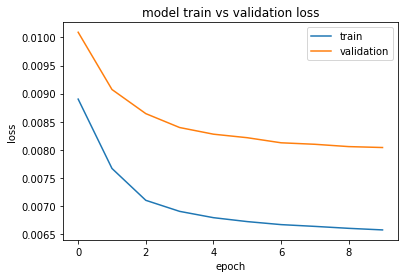

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [53]:
emb.save('embedding.h5')

In [67]:
X_ex = np.array([['Jeanne', 'aime', 'Marie'],
                 ['Jeanne', 'voit', 'Marie'],
                ['Pierre', 'tweetait', 'un', 'message'],
                ['Suzanne', 'googlera', 'la', 'répose'],
                ['Anne',  'est', 'fatiguée']])
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)
test_prediction = emb.predict(X_ex_ci)

In [68]:
print(test_prediction[0])

[  1.50932157e-28   4.19488342e-28   6.96387379e-28   4.69632672e-28
   1.77044830e-28   8.47819784e-28   1.24428399e-28   3.38204372e-28
   1.97782990e-28   3.69363535e-28   4.15935001e-28   4.45710841e-28
   4.45498363e-28   2.80382346e-28   1.17432750e-27   3.80472492e-28
   2.31223803e-28   3.19597746e-28   1.22413236e-30   2.02058170e-28
   4.70681871e-28   0.00000000e+00   3.39368790e-28   1.46501795e-28
   3.34219527e-28   7.52850734e-28   3.06564906e-28   6.27412750e-28
   2.35596386e-28   4.57364499e-28   2.79546107e-28   0.00000000e+00
   7.80759288e-28   8.09328022e-37   8.82074181e-28   0.00000000e+00
   6.40502814e-28   7.96264710e-28   1.68941239e-28   3.51803003e-28
   2.35928224e-28   2.47062097e-28   2.79523742e-28   1.23352768e-28
   3.49994627e-28   4.42313164e-28   1.12639679e-27   2.64646728e-28
   1.13652679e-27   6.10505637e-28   7.81563894e-28   7.34118850e-28
   3.29011089e-31   1.56680294e-27   1.14981305e-29   2.32062377e-28
   2.01347201e-28   4.12191571e-28

In [69]:
def display_pred(X_ex, test_prediction, minprob):
    word_counter = 0
    # iterate over sentences
    for i in range(len(X_ex)):
        # iterate over words
        for j in range(len(X_ex[i])):
            print(X_ex[i][j], end = ': ')
            # iterate over word features
            for k in range(len(test_prediction[word_counter])):
                if test_prediction[word_counter][k] > minprob:
                    print(integer_to_feature[k], end = ' ')
            print('')
            word_counter = word_counter + 1



In [71]:
display_pred(X_ex, test_prediction, 0.05)

Jeanne: np hum 
aime: Obj:(cla|sn) v pers Suj:cln|scompl|sinf|sn nc 
Marie: np hum 
Jeanne: np hum 
voit: v pers Suj:cln|scompl|sinf|sn 
Marie: np hum 
Pierre: nc 
tweetait: Obj:(cla|sn) v pers Suj:cln|scompl|sinf|sn 
un: ms nc 
message: ms nc 
Suzanne: nc 
googlera: Obj:(cla|sn) v pers Suj:cln|scompl|sinf|sn 
la: nc 
répose: v pers Suj:cln|scompl|sinf|sn nc 
Anne: nc 
est: ms P3s adj v fêtre AttSuj pers Att:(de-sinf|scompl|sn) Suj:cln|scompl|sinf|sn nc auxEtre Att:(sa|à-sinf|à-sn) 
fatiguée: Obl2:(par-sn) Obj:(cla|sn) adj active v passive pers Suj:cln|scompl|sinf|sn Suj:cln|sn 
